In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from numpy.linalg import norm
import matplotlib.pyplot as plt

2022-04-16 23:23:02.186951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-16 23:23:02.186982: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#!pip install tensorflow
#!pip install tensorflow_probability

In [3]:
k = 2
n = 1000
N1 = tf.constant(tf.random.normal([k,n], 0, 1, tf.float32, seed=1))
N2 = tf.constant(tf.random.normal([k,n], 0, 1, tf.float32, seed=1))

2022-04-16 23:23:04.695114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-16 23:23:04.695141: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-16 23:23:04.695160: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dell-Inspiron-5448): /proc/driver/nvidia/version does not exist
2022-04-16 23:23:04.695405: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def make_constraint():
    def constraint(L):
        return tf.linalg.band_part(L, -1, 0)
    return constraint

In [5]:
constraint = make_constraint()

In [22]:
total = int((k**2+k)/2)
l = np.ones(total,dtype=np.float32)
L1 = tf.Variable(tfp.math.fill_triangular(l),constraint=constraint)
L2 = tf.Variable(tfp.math.fill_triangular(l),constraint=constraint)
# A = tf.Variable(np.eye(k),dtype=tf.float32)
# B = tf.Variable(np.eye(k),dtype=tf.float32)
M1 = tf.Variable(np.zeros(k),dtype=tf.float32)
M2 = tf.Variable(np.zeros(k),dtype=tf.float32)
p = 0.2
q = 0.5
def loss_fn():
    X1 = L1@N1 + M1[:,None]
    X2 = L2@N2 + M2[:,None]
    X1 = tf.math.l2_normalize(X1, 0) 
    X2 = tf.math.l2_normalize(X2, 0)
    C = tf.matmul(X1,X2,transpose_a=True)
    D = tf.math.square(tf.math.subtract(C,p))
    E = tf.matmul(X1,X1,transpose_a=True)
    F = tf.math.square(tf.math.subtract(E,q))
    G = tf.matmul(X2,X2,transpose_a=True)
    H = tf.math.square(tf.math.subtract(G,q))
    sigma1 = tf.matmul(L1,L1,transpose_b=True)
    sigma2 = tf.matmul(L2,L2,transpose_b=True)
    #+ tf.reduce_sum(F) + tf.reduce_sum(H) 
    # - tf.linalg.logdet(sigma1) - tf.linalg.logdet(sigma2) + tf.norm(sigma1,ord=2) + tf.norm(sigma2,ord=2)
    return tf.reduce_sum(D) + tf.reduce_sum(F) + tf.reduce_sum(H) - tf.linalg.logdet(sigma1) - tf.linalg.logdet(sigma2) 

In [23]:
sigma1 = tf.matmul(L1,L1,transpose_b=True)
sigma2 = tf.matmul(L2,L2,transpose_b=True)
tf.linalg.logdet(sigma1),tf.linalg.logdet(sigma2)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

In [24]:
losses = tfp.math.minimize(
                           loss_fn,
                           num_steps=10000,
                           optimizer=tf.optimizers.Adam(learning_rate=0.1)
                          )

In [25]:
losses

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([2336592.  , 2234338.8 , 2127222.5 , ...,  498654.03,  498654.03,
        498654.  ], dtype=float32)>

In [26]:
sigma1 = tf.matmul(L1,L1,transpose_b=True).numpy()
sigma2 = tf.matmul(L2,L2,transpose_b=True).numpy()

In [27]:
N = 1000
x1 = np.random.multivariate_normal(M1.numpy(),sigma1,N)
x2 = np.random.multivariate_normal(M2.numpy(),sigma2,N)
a = norm(x1,axis=1)
b = norm(x2,axis=1)
a = a.reshape(N,1)
b = b.reshape(N,1)
M = a@b.T
cos_sim = np.divide(x1@x2.T,M)
np.mean(cos_sim.flatten())

0.21441297949299268

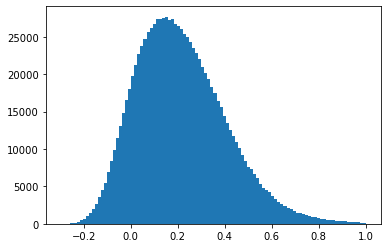

In [28]:
plt.hist(cos_sim.flatten(),100)
plt.show()

In [29]:
M = a@a.T
cos_sim = np.divide(x1@x1.T,M)
np.mean(cos_sim.flatten())

0.9754232926771187

In [30]:
M = b@b.T
cos_sim = np.divide(x2@x2.T,M)
np.mean(cos_sim.flatten())

0.9831981624413174

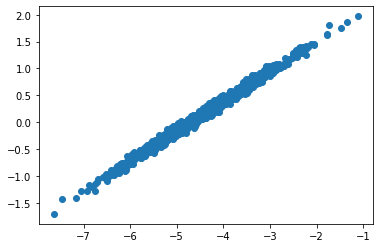

In [31]:
plt.scatter(x1[:,0],x1[:,1])

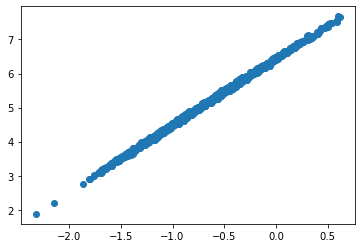

In [32]:
plt.scatter(x2[:,0],x2[:,1])

In [33]:
sigma1,M1.numpy()

(array([[0.9910935 , 0.5559356 ],
        [0.5559356 , 0.31479195]], dtype=float32),
 array([-4.3978763 ,  0.17454135], dtype=float32))

In [34]:
L1

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[0.9955368 , 0.        ],
       [0.558428  , 0.05431506]], dtype=float32)>

In [35]:
sigma2,M2.numpy()

(array([[0.28189394, 0.55190223],
        [0.55190223, 1.0818168 ]], dtype=float32),
 array([-0.6752087,  5.1234097], dtype=float32))